#Recommandation System

In this project, we aim to build a personalized recommendation system using the Amazon Books Reviews dataset, a large-scale collection of user-generated content and interaction records from the Amazon platform. This dataset captures valuable insights into user preferences and reading behaviors by compiling a vast number of book reviews submitted by Amazon users over time.
https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews


In [1]:
# !pip install sentence-transformers

# Data Preparation

The dataset is structured into two main files:

Books_data: This file contains detailed information about each book, including the book's title, author, publication details, and sometimes a summary or description. This serves as the content information for content-based recommendation approaches.

Book_rating: This file records the interaction data between users and books. It includes the user ID, book ID, numerical ratings (typically on a scale of 1 to 5), and occasionally timestamps or review text. This file provides the core data for collaborative filtering techniques, as it reflects user preferences based on previous ratings.

In [2]:
import pandas as pd
import numpy as np

import kagglehub
from kagglehub import KaggleDatasetAdapter
pd.options.mode.chained_assignment = None

In [3]:
# Load the latest version
# books_rating = kagglehub.load_dataset(
#   KaggleDatasetAdapter.PANDAS,
#   "mohamedbakhet/amazon-books-reviews",
#   "Books_rating.csv",
#   # Provide any additional arguments like
#   # sql_query or pandas_kwargs. See the
#   # documenation for more information:
#   # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
# )

# Load the latest version
# books_data = kagglehub.load_dataset(
#   KaggleDatasetAdapter.PANDAS,
#   "mohamedbakhet/amazon-books-reviews",
#   "books_data.csv",
#   # Provide any additional arguments like
#   # sql_query or pandas_kwargs. See the
#   # documenation for more information:
#   # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
# )

books_rating = pd.read_csv("Books_rating.csv")
books_data = pd.read_csv("books_data.csv")


## Clean

Since the original dataset is very large and diverse, it can be challenging to work with directly, especially for tasks focused on learning the basic principles of recommendation systems. To make the problem more manageable and easier to interpret, we apply a series of data filtering steps aimed at reducing complexity while preserving meaningful structure.

In [4]:
import ast
from collections import Counter

# Assuming books_data is your DataFrame
books_data = books_data.dropna()
books_data['categories'] = books_data['categories'].apply(ast.literal_eval)

First, we identify the top-level categories (or genres) that have a substantial number of books. Specifically, we select only those categories that contain more than 500 books, ensuring that we focus on well-represented and popular genres where meaningful recommendations can be made.

In [5]:
# Flatten all categories and count occurrences
all_categories = [cat for sublist in books_data['categories'] for cat in sublist]
category_counts = Counter(all_categories)

sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
unique_categories_sorted = sorted(category_counts.keys())
popular_categories = {category for category, count in sorted_categories if count > 500}
books_data['categories'] = books_data['categories'].apply(
    lambda cats: [cat for cat in cats if cat in popular_categories]
)

# Now filter the DataFrame to only keep books that have at least one popular category
filtered_books = books_data[
    books_data['categories'].apply(len) > 0
].copy()

books_data = filtered_books
books_data

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,[Religion],5.0
31,Voices from the Farm: Adventures in Community ...,"Twenty-five years ago, at the height of the co...",['Rupert Fike'],http://books.google.com/books/content?id=IjTAB...,http://books.google.nl/books?id=IjTABgAAQBAJ&p...,Book Publishing Company,2012-08-21,https://play.google.com/store/books/details?id...,[Biography & Autobiography],1.0
33,The Battleship Bismarck,The Bismarck is perhaps the most famous – and ...,['Stefan Draminski'],http://books.google.com/books/content?id=nxttD...,http://books.google.nl/books?id=nxttDwAAQBAJ&p...,Bloomsbury Publishing,2018-09-20,https://play.google.com/store/books/details?id...,[History],1.0
42,Tess and the Highlander,"In 1543, on a windswept isle off of Scotland, ...",['May Mcgoldrick'],http://books.google.com/books/content?id=VmCRS...,http://books.google.nl/books?id=VmCRSPmY3WkC&d...,Harper Collins,2002-11,http://books.google.nl/books?id=VmCRSPmY3WkC&d...,[Juvenile Fiction],2.0
54,"Open marriage;: A new life style for couples,",Advocates the importance of individuality in b...,"[""Nena O'Neill"", ""George O'Neill""]",http://books.google.com/books/content?id=xY2SD...,http://books.google.nl/books?id=xY2SD7v3070C&p...,Rowman & Littlefield,1984,http://books.google.nl/books?id=xY2SD7v3070C&d...,[Family & Relationships],1.0
...,...,...,...,...,...,...,...,...,...,...
212365,The Road Back,The sequel to the masterpiece All Quiet on the...,['Erich Maria Remarque'],http://books.google.com/books/content?id=obZdA...,http://books.google.com/books?id=obZdAAAAQBAJ&...,Random House Trade Paperbacks,1998-01-27,http://books.google.com/books?id=obZdAAAAQBAJ&...,[Fiction],6.0
212374,Thin Within,"I want to lose weight, but dieting just doesn'...","['Judy Halliday', 'Arthur Halliday']",http://books.google.com/books/content?id=L_YV_...,http://books.google.com/books?id=L_YV_kuQwk8C&...,Thomas Nelson,2005-04-17,https://play.google.com/store/books/details?id...,[Health & Fitness],9.0
212394,Final things,Grace's father believes in science and builds ...,['Jenny Offill'],http://books.google.com/books/content?id=UbSFB...,http://books.google.com/books?id=UbSFBAAAQBAJ&...,Vintage,2015-03-17,https://play.google.com/store/books/details?id...,[Fiction],4.0
212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",['Elvira Woodruff'],http://books.google.com/books/content?id=J7M-N...,http://books.google.com/books?id=J7M-NwAACAAJ&...,Scholastic Paperbacks,2000-06-01,http://books.google.com/books?id=J7M-NwAACAAJ&...,[Juvenile Fiction],2.0


## get only 10000 sample of book for this Homework

After filtering by category, we then randomly sample 10,000 books from this subset. This step balances dataset size and diversity, making it more suitable for prototyping and educational purposes, while still retaining enough data for both content-based and interaction-based modeling.

In [6]:
books_data = books_data.sample(n=10000, random_state=42)
books_rating = books_rating[books_rating['Title'].isin(books_data['Title'])]

## turn unix time to datetime format

In [7]:
# Convert Unix time to datetime
books_rating['datetime'] = pd.to_datetime(books_rating['review/time'], unit='s')

# Extract year to a new column
books_rating['year'] = books_rating['datetime'].dt.year

## Drop null user, rating

In [8]:
books_rating.dropna(subset=['User_id', 'review/score'], inplace=True)
books_rating.drop(columns=['Price', 'profileName', 'review/helpfulness', 'review/time', 'review/summary', 'review/text'], inplace=True)

books_rating = books_rating.sort_values(['User_id', 'Title', 'datetime'], ascending=[True, True, False])
books_rating.drop_duplicates(subset=['Title', 'User_id'], inplace=True)

In [9]:
books_rating['User_id'] = pd.factorize(books_rating['User_id'])[0]

In [10]:
books_rating.head()

,Id,Title,User_id,review/score,datetime,year
1190823,0767908392,The Queen of Harlem: A Novel,0,5.0,2013-02-20,2013
2290392,B000KP4BMI,The Window of Larkspur Inn (The Gresham Chroni...,1,5.0,2013-01-17,2013
2600929,0890512930,Biblical Creationism,2,5.0,2013-01-13,2013
524186,B000IEZE3G,Harry Potter and The Sorcerer's Stone,3,5.0,2012-12-26,2012
2237510,B000BI3IBO,If You Give a Mouse a Cookie (Book and Audio C...,4,5.0,2013-01-10,2013


##  Train/Test Split

To create a more realistic recommendation setup, we splited the dataset based on time, using 2010 as the cutoff. Reviews before 2010 are used for training, and those from 2010 onward for testing, simulating how models learn from past behavior to predict future preferences.

We further filter the training set to include only users with at least 5 reviews, ensuring the model has enough data to learn from. The test set is limited to users who also appear in the training set, allowing consistent evaluation and avoiding cold-start issues.

This time-aware approach helps prevent data leakage and overfitting, leading to a more reliable and interpretable recommendation system.

In [11]:
year = 2010
train = books_rating[books_rating['year'] < year]
user_counts = train["User_id"].value_counts()
users_with_5plus = user_counts[user_counts >= 5].index
train = train[train["User_id"].isin(users_with_5plus)]
test = books_rating[books_rating['year'] >= year]
test = test[test['User_id'].isin(train['User_id'])]
test = test[test['Id'].isin(train['Id'])]

In [12]:
print("train: ",len(train))
print("test:  ",len(test))

train:  34656
test:   2491


In recommender systems, user feedback generally falls into two main categories: explicit feedback and implicit feedback.


### TODO 1: Based on the given dataset, is the feedback explicit or implicit?

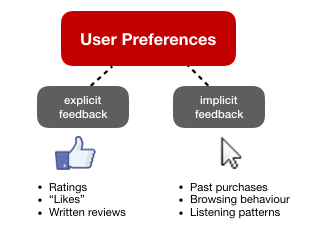

Ans: Explicit

# Feature Extraction

To enable content-based recommendation, we need to extract meaningful features that describe each book. In our case, we focus on two key types of content features:


## Catergories

Catergories (One-Hot Encoding):
We use the book's genre (or category) as a categorical feature and apply one-hot encoding to represent it in a machine-readable format. This allows the model to understand similarities between books based on their genre.

In [13]:
exploded_categories = books_data['categories'].explode()
one_hot = pd.get_dummies(exploded_categories, prefix='cat')
one_hot_encoded = one_hot.groupby(level=0).max()
one_hot_encoded.head()

,cat_Biography & Autobiography,"cat_Body, Mind & Spirit",cat_Business & Economics,cat_Computers,cat_Cooking,cat_Family & Relationships,cat_Fiction,cat_Health & Fitness,cat_History,cat_Juvenile Fiction,cat_Juvenile Nonfiction,cat_Philosophy,cat_Religion,cat_Science,cat_Social Science
42,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
67,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
73,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
128,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
177,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


## Title and Description

Text Embeddings (Title + Description):
To capture the semantic meaning of the book content, we combine the book's title and description into a single text string. Then, we use a sentence transformer (e.g., a pre-trained model from the sentence-transformers library) to convert this text into a dense vector embedding. These embeddings encode the underlying meaning of the text and allow the model to compute similarity between books in a meaningful way.

In [14]:
from sentence_transformers import SentenceTransformer

In [15]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

In [16]:
books_data["text"]  = books_data["Title"] + '. ' + books_data["description"]
embeddings = model.encode(books_data["text"].tolist())

## Combine To Create Dataset

In [17]:
books_data['text_embeddings'] = embeddings.tolist()

book_dataset = pd.concat([
    books_data[["Title", "text_embeddings"]],
    one_hot_encoded,
], axis=1)

book_dataset.head()

,Title,text_embeddings,cat_Biography & Autobiography,"cat_Body, Mind & Spirit",cat_Business & Economics,cat_Computers,cat_Cooking,cat_Family & Relationships,cat_Fiction,cat_Health & Fitness,cat_History,cat_Juvenile Fiction,cat_Juvenile Nonfiction,cat_Philosophy,cat_Religion,cat_Science,cat_Social Science
88230,Dr Haggards Disease,"[-0.006928980350494385, 0.100972980260849, -0....",False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
7255,"American Science Fiction TV: Star Trek, Starga...","[0.17040036618709564, -0.30659911036491394, 0....",False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
118038,Dearest Friend: A Life of Abigail Adams,"[-0.14214184880256653, -0.1484207808971405, -0...",True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10658,American Mania: When More is Not Enough,"[0.2640315890312195, -0.005020105745643377, 0....",False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
114824,"A Kiss of Shadows (Meredith Gentry, Book 1)","[0.016347261145710945, -0.2993292808532715, -0...",False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [18]:
train_rating = train.merge(book_dataset, how='inner', on='Title')
test_rating = test.merge(book_dataset, how='inner', on='Title')

# Collaborative Filtering

Collaborative filtering is a popular technique in recommendation systems that relies on user behavior to make recommendations. It works by grouping users with similar preferences or behavior patterns and recommends new items based on the shared characteristics of the group. This method doesn't require knowledge of the content itself — instead, it leverages historical interactions (such as ratings, views, or purchases) to make predictions.

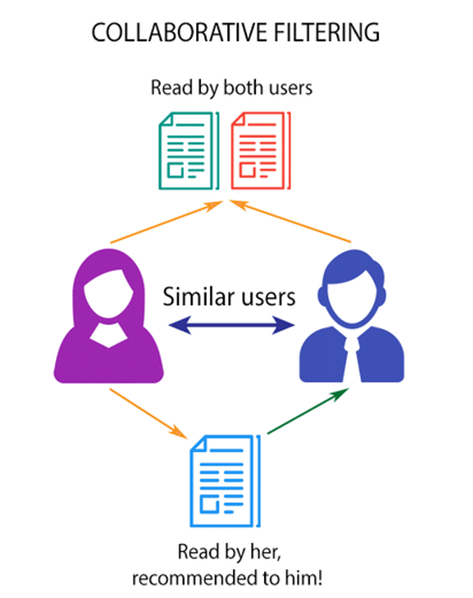

## User-Item Interaction

To implement this, we first need to convert the interaction data into a sparse matrix. The rows of this matrix represent users, and the columns represent items (e.g., books). Each entry in the matrix contains a value representing the user’s interaction with the item, such as a rating or a binary indicator (e.g., whether the user has viewed or purchased the item).


In [19]:
train = train.dropna(subset=["User_id"])
train_interaction = train[["Id", "User_id", "review/score"]].copy()
train_interaction.columns = ["item_id", "user_id", "weight"]

In [20]:
test = test.dropna(subset=["User_id"])
test_interaction = test[["Id", "User_id", "review/score"]].copy()
test_interaction.columns = ["item_id", "user_id", "weight"]

In [21]:
train_interaction

,item_id,user_id,weight
1039039,1564559181,202,5.0
2175610,B0001PIOWU,202,4.0
2898139,B000GM4X0A,202,3.0
1556172,0944344496,202,5.0
2112715,B00008HBR9,202,4.0
...,...,...,...
1485708,0785745521,177525,5.0
2762340,0764227122,177525,5.0
516240,0553253816,177525,5.0
2108485,0785745629,177525,5.0


In [22]:
test_interaction

,item_id,user_id,weight
2855181,B0006E1KQ8,268,4.0
485477,B0000CMP8O,268,4.0
320832,B0006D6XAM,268,3.0
2264482,B000KPU0KU,1412,4.0
510977,B000Q7QGC8,1499,5.0
...,...,...,...
2653761,0060971231,175936,4.0
1093851,B0006AL5K8,175936,4.0
345808,B0006DBN8E,176072,5.0
1316418,B000U2H82Q,176683,5.0


## Matrix Factorization

In this project, we implement collaborative filtering using Matrix Factorization. Matrix factorization decomposes the large user-item interaction matrix into two smaller matrices, one representing user preferences and the other representing item characteristics. The model then learns to predict missing values (such as unseen ratings or interactions) based on these latent factors. This technique helps us uncover hidden relationships between users and items, providing personalized recommendations.

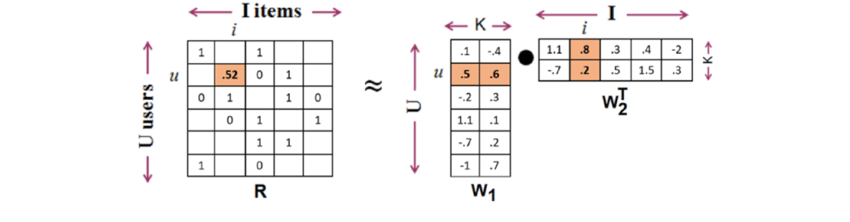

In [23]:
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
from tqdm import tqdm

In [24]:
 # Create mappings from user/item to their indices
user_ids = train_interaction["user_id"].unique()
item_ids = train_interaction["item_id"].unique()

user_to_idx = {u: i for i, u in enumerate(user_ids)}
item_to_idx = {i: idx for idx, i in enumerate(item_ids)}

idx_to_user = {i: u for u, i in user_to_idx.items()}
idx_to_item = {i: j for j, i in item_to_idx.items()}

n_users = len(user_ids)
n_items = len(item_ids)

# Convert dataframe to sparse matrix
rows = train_interaction["user_id"].map(user_to_idx)
cols = train_interaction["item_id"].map(item_to_idx)
values = train_interaction["weight"].values

# Create sparse rating matrix
ratings = coo_matrix((values, (rows, cols)),
                        shape=(n_users, n_items)).tocsr()

ratings = ratings.toarray()
unk = 0
ratings[ratings  == 0] = unk
R = ratings.copy()

We initialize the user factors matrix (U) and item factors matrix (V) randomly with small values. These matrices represent the latent factors (hidden features) of users and items, respectively.

In [25]:
num_users, num_items = R.shape
num_factors = 40
np.random.seed(42)
# Random initialization of user and item factors
U = np.random.rand(num_users, num_factors) * 0.01
V = np.random.rand(num_items, num_factors) * 0.01

We set a regularization parameter (lambda_reg) and define the number of training iterations (num_iterations). The regularization term helps prevent overfitting by penalizing large values in the factor matrices.

In [26]:
lambda_reg = 0.1
num_iterations = 200

In [27]:
def train_matrix_factorization(unk):
    """
    The function train_matrix_factorization() performs the core optimization process,
    where we update the user and item factors alternately using the Alternating Least Squares (ALS) method.
    """
    global U, V
    for iteration in tqdm(range(num_iterations)):
        # Update user factors
        """
        For each user, we look at the items they have rated (i.e., where the rating is not unk).
        We then update the user’s preferences by solving a least squares problem using the item factors for the rated items.
        """
        for u in range(num_users):
            V_u = V[R[u, :] != unk, :]
            R_u = R[u, R[u, :] != unk]
            if V_u.shape[0] > 0:
                U[u, :] = np.linalg.solve(
                    np.dot(V_u.T, V_u) + lambda_reg * np.eye(num_factors),
                    np.dot(V_u.T, R_u)
                )

        # Update item factors
        """
        Similarly, for each item, we update the item factors using the user factors for all users who have rated that item.
        """
        for i in range(num_items):
            U_i = U[R[:, i] != unk, :]
            R_i = R[R[:, i] != unk, i]
            if U_i.shape[0] > 0:
                V[i, :] = np.linalg.solve(
                    np.dot(U_i.T, U_i) + lambda_reg * np.eye(num_factors),
                    np.dot(U_i.T, R_i)
                )

train_matrix_factorization(unk)

100%|██████████| 200/200 [02:33<00:00,  1.30it/s]


In [28]:
import numpy as np
import math

user_vector = U.copy()
item_vector = V.copy()

## Evaluation

Prediction: Reconstructing the Sparse Matrix
In collaborative filtering, after we have learned the user vectors (representing user preferences) and item vectors (representing item characteristics) through matrix factorization, we can use these vectors to predict missing values in the original sparse interaction matrix.

The user vector and item vector are latent feature representations for users and items, respectively. By multiplying the user vector (U) with the item vector (V), we obtain predicted ratings for user-item pairs that were previously missing in the sparse matrix.


This operation reconstructs the sparse matrix by filling in the previously missing entries with predicted values. The resulting predicted scores are then used to recommend items for users based on their predicted preferences.

To get the predicted ratings for a given user, we multiply the user's latent feature vector with the latent feature vectors of all items in the system. This will provide a predicted score for each item, representing how likely the user is to rate (or interact with) the item.

For each user, we compute their predicted ratings for all items by performing a matrix multiplication between the user vector and the item matrix (V), which is the collection of item vectors (one for each item). This results in a score for every item for that user.

`item_score = user_vector[u] @ item_vector.T`

Here, the `user_vector[u]` is multiplied by the transposed item matrix (`item_vector.T`) to obtain scores for all items that user has not yet interacted with.

Normalization: After calculating the predicted scores, we often normalize them to fall within the desired rating range (in this case, 1-5) by scaling the predicted values. This step ensures the predicted ratings are interpretable.

By performing this matrix multiplication for each user in the system, we can fill in the missing entries in the interaction matrix, thereby predicting how much a user might like each item based on their learned preferences and the item characteristics.

In [29]:
mse_list = []
for u in range(len(user_vector)):
    item_score = user_vector[u] @ item_vector.T
    item_score = (item_score - item_score.min()) / (item_score.max() - item_score.min()) * 5
    user_id = idx_to_user[u]
    user_data = test_interaction[test_interaction["user_id"] == user_id]

    if not user_data.empty:
        item_list = user_data["item_id"].tolist()
        rating_list = user_data["weight"].tolist()

        for i in range(len(item_list)):
            item_idx = item_to_idx.get(item_list[i])
            if item_idx is not None:
                pred = math.ceil(item_score[item_idx])
                true = rating_list[i]
                mse_list.append((pred - true) ** 2)

# Final MSE
mse = np.mean(mse_list)
print("MSE:", mse)


MSE: 1.669610598153352


### TODO 2: From user_vector and item_vector , Generate top-20 book recommendations for each user, excluding any books they have already rated in train. (based on `item_score = user_vector[u] @ item_vector.T`)

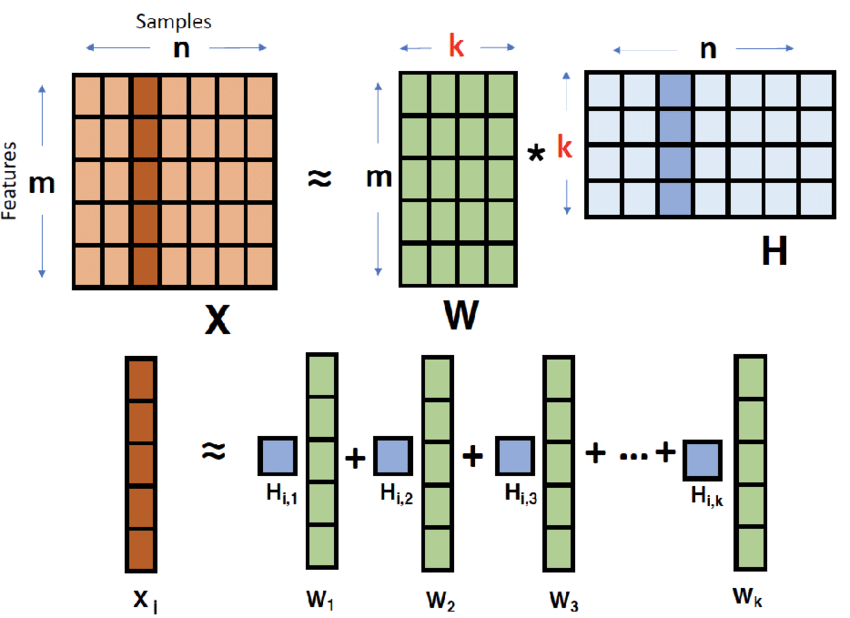

In [30]:
top_k = 20
user_top_k_recs = {}
## CODE HERE ###
# Hint: check the evaluation code, how to convert score to fit in range 0-5
for u in range(len(user_vector)):
    item_score = user_vector[u] @ item_vector.T
    item_score = (item_score - item_score.min()) / (item_score.max() - item_score.min()) * 5
    user_id = idx_to_user[u]
    rated_items = train_interaction[train_interaction["user_id"] == user_id]["item_id"].tolist()
    rated_item_index = [item_to_idx[item] for item in rated_items if item in item_to_idx]
    item_score[rated_item_index] = -1  
    top_k_items = np.argsort(item_score)[-top_k:][::-1] 
    top_k_item_ids = [item_ids[idx] for idx in top_k_items]
    user_top_k_recs[user_id] = top_k_item_ids


In [31]:
for i in user_top_k_recs[52983]:
    idx = item_to_idx[i]
    print((i, float(item_score[idx])))

('B000NSFDQK', 3.907891159772533)
('B0006CWGKE', 4.36383474622171)
('B000PCPLS4', 3.409551548193553)
('B000PIIMPW', 4.480875119596586)
('B000I5MM8A', 3.795843170536482)
('B000NIOKGY', 4.345449975310956)
('B000KF8HTG', 4.046513750218183)
('B000GRK90S', 4.313486445997776)
('B000IEZE3G', 3.4923711372485484)
('0743436164', 4.442839201636649)
('B000CRFW9A', 4.092779677101481)
('B000P18Z2O', 3.461471168195811)
('B0007EDZRY', 3.532958190834206)
('9993183709', 4.4675447032408915)
('B000HJNEYS', 3.947385638203386)
('B0007G64NO', 3.898037994800721)
('0792737822', 4.538113403137017)
('B000KHZ3QE', 3.9634928332139725)
('0786258918', 3.1734937782115136)
('034073891X', 4.257442558152919)


For user_id = 52983, should get (not necessary to be exactly the same at decimal level)
```
[
 ('B000NSFDQK', 5.0),
 ('B0006CWGKE', 4.690235616564033),
 ('B000PCPLS4', 4.563453567417001),
 ('B000PIIMPW', 4.533352521289076),
 ('B000I5MM8A', 4.4182726821962985),
 ('B000NIOKGY', 4.412939047427911),
 ('B000KF8HTG', 4.407360158668951),
 ('B000GRK90S', 4.407210202908275),
 ('B000IEZE3G', 4.406401202943635),
 ('0743436164', 4.381658336736284),
 ('B000CRFW9A', 4.3535383526001254),
 ('B000P18Z2O', 4.340717764836055),
 ('B0007EDZRY', 4.330200895353807),
 ('9993183709', 4.327618731466481),
 ('B000HJNEYS', 4.324314833610357),
 ('B0007G64NO', 4.27289062110324),
 ('0792737822', 4.258248751288252),
 ('B000KHZ3QE', 4.236991629035886),
 ('0786258918', 4.236101547138868),
 ('034073891X', 4.234663302746484)
 ]
```

# Content Based

Content-based filtering is an information retrieval method that uses item features to select and return items relevant to a user’s query. This method often takes features of other items in which a user expresses interest into account. Content-based is a bit of a misnomer however. Some content-based recommendation algorithms match items according to descriptive features (i.e., metadata) attached to items rather than the actual content of an item. Nevertheless, several content-based methods. (i.e., content-based image retrieval or natural language processing applications—do match items according to intrinsic item attributes)


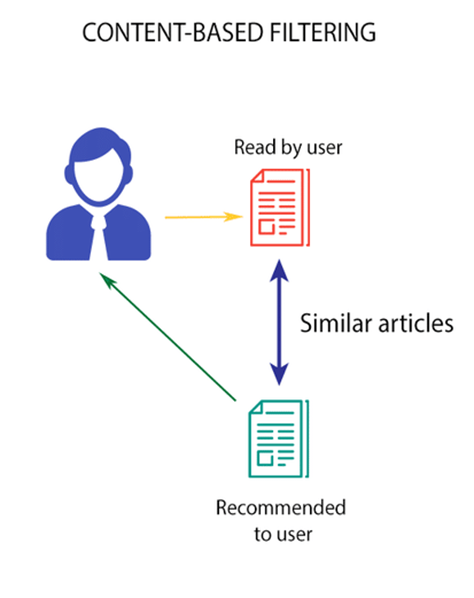

In this exercise, we will recommend unreviewed books to users based on the predicted rating of those books. In the first section, we will create a model to predict book ratings for unreviewed books based on users' past reviews.

## User Id Solution

In the first solution, we will use user_id, book categories, and text embeddings of book titles and descriptions as features to predict rating scores

In [32]:
# Prepare train and test data which are user_id, book categories and text_embeddings of book titles and descriptions
# Predict rating (review/score)

X_train = train_rating[['User_id'] + \
                        one_hot_encoded.columns.tolist()
                        ].to_numpy()

X_train = np.concatenate([X_train, np.array(train_rating['text_embeddings'].tolist())], axis=1)

y_train = train_rating['review/score']

X_test = test_rating[['User_id'] + \
                        one_hot_encoded.columns.tolist()
                        ].to_numpy()

X_test = np.concatenate([X_test, np.array(test_rating['text_embeddings'].tolist())], axis=1)

y_test = test_rating['review/score']

### TODO 3.1: Build XGBoost model to create content based filtering model and find MSE score of the model.

In [33]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [34]:
#### CODE HERE ####
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=200,  
    learning_rate=0.05,  
    max_depth=8,  
    random_state=1234
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [35]:
# Evaluate review/score with mse metrics
min_score, max_score = 0, 5
#### CODE HERE ####
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")


Mean Squared Error (MSE): 0.8642493705896744


### TODO 3.2: Normaly we wouldn't use user id as a feature, Why?

Ans: User ID are unique and can lead to overfitting, also user ID does not contain user behavior data

## User Embeddings Solution

In this solution, we will create user embeddings for the model instead of using user_id. There are many ways to create user embeddings, but for this exercise, we selected the text embeddings of the book with the highest individual review score for each user.

In [36]:
# Finding the most rated book for each user. If there are 2 or more books with the highest rating, the most recent one will be used.
def weighted_avg_top_n_embeddings(df, n=5):
    user_embeddings = {}

    df_sorted = df.sort_values(['User_id', 'review/score', 'datetime'], ascending=[True, False, False])

    for user_id, group in df_sorted.groupby('User_id'):
        top_n = group.head(n)

        weights = top_n['review/score'].values
        embeddings = np.stack(top_n['text_embeddings'].values)

        weights = weights / weights.sum()

        weighted_embedding = np.average(embeddings, axis=0, weights=weights)

        user_embeddings[user_id] = weighted_embedding

    return user_embeddings

In [37]:
user_embeddings = weighted_avg_top_n_embeddings(train_rating, 1)

In [38]:
train_rating['user_embeddings'] = train_rating['User_id'].map(user_embeddings)
test_rating['user_embeddings'] = test_rating['User_id'].map(user_embeddings)

In [39]:
test_rating

,Id,Title,User_id,review/score,datetime,year,text_embeddings,cat_Biography & Autobiography,"cat_Body, Mind & Spirit",cat_Business & Economics,...,cat_Fiction,cat_Health & Fitness,cat_History,cat_Juvenile Fiction,cat_Juvenile Nonfiction,cat_Philosophy,cat_Religion,cat_Science,cat_Social Science,user_embeddings
0,B0006E1KQ8,The Mangan inheritance,268,4.0,2012-07-20,2012,"[-0.17252177000045776, 0.14521357417106628, -0...",False,False,False,...,True,False,False,False,False,False,False,False,False,"[0.019812151789665222, 0.12745703756809235, -0..."
1,B0000CMP8O,The Millstone,268,4.0,2011-03-12,2011,"[0.09369620680809021, -0.13554872572422028, -0...",False,False,False,...,True,False,False,False,False,False,False,False,False,"[0.019812151789665222, 0.12745703756809235, -0..."
2,B0006D6XAM,The Spy Who Came In From the Cold,268,3.0,2011-11-06,2011,"[-0.37328195571899414, 0.12529827654361725, -0...",False,False,False,...,True,False,False,False,False,False,False,False,False,"[0.019812151789665222, 0.12745703756809235, -0..."
3,B000KPU0KU,Man Who Ate Everything,1412,4.0,2011-08-06,2011,"[0.11606423556804657, -0.11528254300355911, -0...",False,False,False,...,False,False,False,False,False,False,False,False,False,"[0.452089786529541, -0.24501261115074158, 0.03..."
4,B000Q7QGC8,Blow Up and Other Stories,1499,5.0,2012-07-07,2012,"[0.11299232393503189, -0.017953066155314445, -...",False,False,False,...,True,False,False,False,False,False,False,False,False,"[-0.10308095812797546, 0.07773701846599579, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2486,0060971231,In His Own Write,175936,4.0,2010-05-02,2010,"[-0.25685080885887146, 0.2927987277507782, -0....",False,False,False,...,True,False,False,False,False,False,False,False,False,"[0.08184327185153961, -0.23445706069469452, -0..."
2487,B0006AL5K8,The Murder at the vicarage;: A detective story,175936,4.0,2010-03-23,2010,"[0.29365378618240356, 0.004810013808310032, -0...",False,False,False,...,True,False,False,False,False,False,False,False,False,"[0.08184327185153961, -0.23445706069469452, -0..."
2488,B0006DBN8E,Voltaire In Love,176072,5.0,2010-09-12,2010,"[-0.06647967547178268, 0.2228788584470749, -0....",True,False,False,...,False,False,False,False,False,False,False,False,False,"[-0.05653613805770874, -0.04750073701143265, -..."
2489,B000U2H82Q,Maximum Bob.,176683,5.0,2010-06-13,2010,"[-0.09960000962018967, 0.05931280925869942, -0...",False,False,False,...,True,False,False,False,False,False,False,False,False,"[-0.033185042440891266, -0.07698997110128403, ..."


We will use user embeddings, book categories, and text embeddings of book titles and descriptions as features to predict rating scores.

In [40]:
# Prepare train and test data which are user_embeddings, book categories and text_embeddings of book titles and descriptions
# Predict rating (review/score)

X_train = train_rating[one_hot_encoded.columns.tolist()].to_numpy()

X_train = np.concatenate([np.array(train_rating['user_embeddings'].tolist()), X_train, np.array(train_rating['text_embeddings'].tolist())], axis=1)

y_train = train_rating['review/score']

X_test = test_rating[one_hot_encoded.columns.tolist()].to_numpy()

X_test = np.concatenate([np.array(test_rating['user_embeddings'].tolist()), X_test, np.array(test_rating['text_embeddings'].tolist())], axis=1)

y_test = test_rating['review/score']

### TODO 3.3: Build XGBoost model to create content based filtering model. Also find MSE score of the model.

In [41]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#### CODE HERE ####
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=200,  
    learning_rate=0.05,  
    max_depth=8,  
    random_state=1234
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [42]:
# Evaluate review/score with mse metrics
min_score, max_score = 0, 5
#### CODE HERE ####
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.8227808585506912


### TODO 3.4: According to 3.1 and 3.3. <br>Which method have better performance? Why?

Ans: 3.3 has better performance. Because it is using user embedding instead of user id, which helps the model to be better and generalization and less overfitting

## Recommend all unreviewed books

After training a model to predict the ratings for books that a user has not yet reviewed, we generate personalized book recommendation lists for each user based on the predicted rating scores. Since user ratings come from transaction data, the next reviewed books in the transaction sequence reflect the user's interests and are considered suitable recommendations.

In this section, we use the test data to represent the next books that the user is interested in (i.e., books they reviewed or rated).

First, for each user, we predict the ratings of all unreviewed books and sort them by the predicted rating score. In this exercise, we use the top 20 books to form the recommendation list.

In [43]:
def recommend_items(test_rating, train_rating, model, top_k=5):

    user_recommendations = {}

    for user_id, user_group in test_rating.groupby('User_id') :
        rated_items = set(train_rating[train_rating['User_id'] == user_id]['Title'])
        all_items = set(book_dataset['Title'].tolist())
        candidate_items = all_items - rated_items

        book_candidates = book_dataset[book_dataset['Title'].isin(candidate_items)]

        book_cat = book_candidates[one_hot_encoded.columns.tolist()].to_numpy()
        book_embeddings = np.array(book_candidates['text_embeddings'].tolist())
        user_embeddings = np.array(user_group['user_embeddings'].iloc[0].tolist())

        user_embeddings = np.broadcast_to(user_embeddings, (book_embeddings.shape[0], user_embeddings.shape[-1]))

        book_candidates['score'] = model.predict(np.concatenate([user_embeddings, book_cat, book_embeddings], axis=1))

        user_recommendations[user_id] = book_candidates[['Title', 'score']].sort_values('score', ascending=False).head(top_k).to_numpy()

    return user_recommendations


In [44]:
user_next_rating = test_rating.sort_values('datetime', ascending=True)

In [45]:
user_recommendations_list = recommend_items(user_next_rating, train_rating, xgb_model, top_k=20)

## Evaluation

These are the widely used recommendation metrics for our project. We'd like you to focus on implementing Hit Rate@K and MRR@K.

https://www.evidentlyai.com/ranking-metrics/evaluating-recommender-systems

### TODO 4: complete hit rate func. (K = 20)

In [46]:
def hit_rate_at_k(predictions, ground_truth, k=5):
    hits = 0
    total = len(ground_truth)
    #### CODE HERE ####
    for user_id, user_recommendations in predictions.items():
        recommended_items = set(user_recommendations[:, 0])
        actual_items = set(ground_truth[ground_truth['User_id'] == user_id]['Title'].tolist())
        hits += len(recommended_items.intersection(actual_items)) > 0
    print(f"Hits: {hits}, Total: {total}")

    return hits / total

In [47]:
hit_rate_at_k(user_recommendations_list, user_next_rating[['User_id', 'Title']], k=20)

Hits: 32, Total: 2491


0.012846246487354477

### TODO 5: complete MRR@K func. (K = 20)

In [48]:
def mrr_at_k(predictions, ground_truth, k=5):
    rr_total = 0
    total = len(ground_truth)
    #### CODE HERE ####
    for user_id, user_recommendations in predictions.items():
        recommended_items = [item[0] for item in user_recommendations[:k]]
        actual_items = ground_truth[ground_truth['User_id'] == user_id]['Title'].tolist()
        
        for rank, item in enumerate(recommended_items, start=1):
            if item in actual_items:
                rr_total += 1 / rank
                break
    print(f"RR Total: {rr_total}, Total: {total}")
    return rr_total / total

In [49]:
mrr_at_k(user_recommendations_list, user_next_rating[['User_id', 'Title']], k=20)

RR Total: 10.468616982432774, Total: 2491


0.004202576066813638